# Validation of method

### Table of contents

1. [**SVGP**](#svgp)
3. [**SSGP**](#ssgp)
4. [**STGP**](#stgp)



In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np

import sys
sys.path.append("..")


import jax
import jax.numpy as jnp
import jax.random as jr
from jax.nn import softplus

import optax

jax.config.update('jax_platform_name', 'cpu')
#jax.config.update('jax_disable_jit', True)
jax.config.update("jax_enable_x64", True)

#import os
#if not os.path.exists('./saves'):
#    os.makedirs('./saves')


import pickle


import lib


import matplotlib.pyplot as plt
plt.style.use(['../paper.mplstyle'])

/var/home/dl543/Documents/Learning/nonparametric-modulated-renewal/notebooks/../lib/inference.py:17: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


<a id='svgp'></a>
## SVGP

### 2D

In [97]:
x_dims = 2
f_dims = 3

jitter = 1e-12

n_samp = 10

prng_state = jax.random.PRNGKey(123)

In [98]:
len_fx = 1.*np.ones((f_dims, x_dims))  # GP lengthscale
var_f = 1.*np.ones(f_dims)  # observation noise
kern = lib.GP.kernels.SquaredExponential(f_dims, variance=var_f, lengthscale=len_fx)
mean_f = np.zeros(f_dims)
num_induc = 5
induc_locs = jax.random.normal(prng_state, shape=(f_dims, num_induc, x_dims))

prng_state, _ = jr.split(prng_state)


mode = 'tSVGP'
if mode == 'qSVGP':
    u_mu = 1.*jax.random.normal(prng_state, shape=(f_dims, num_induc, 1))
    u_Lcov = 0.*jnp.eye(num_induc)[None, ...].repeat(f_dims, axis=0)
    
    svgp = lib.GP.sparse.qSVGP(kern, mean_f, induc_locs, u_mu, u_Lcov, RFF_num_feats=0)
    
    Kzz = svgp.kernel.K(svgp.induc_locs, None, False)
    lambda_1, chol_Lambda_2 = lib.GP.sparse.q_to_t_svgp_moments(Kzz, u_mu, u_Lcov)
    
elif mode == 'tSVGP':
    lambda_1 = 1.*jax.random.normal(prng_state, shape=(f_dims, num_induc, 1))
    chol_Lambda_2 = 100.*jnp.eye(num_induc)[None, ...].repeat(f_dims, axis=0)
    
    svgp = lib.GP.sparse.tSVGP(kern, mean_f, induc_locs, lambda_1, chol_Lambda_2, RFF_num_feats=100)
    
    Kzz = svgp.kernel.K(svgp.induc_locs, None, False)
    u_mu, u_Lcov = lib.GP.sparse.t_to_q_svgp_moments(Kzz, lambda_1, chol_Lambda_2, jitter)

In [99]:
prng_state, _ = jr.split(prng_state)

xx = np.meshgrid(*[np.linspace(-3, 3, 30) for _ in range(x_dims)])
xx = jnp.stack(xx, axis=-1)

or_shape = xx.shape[:-1]
xx = xx.reshape(1, 1, -1, x_dims)  # (samp, out_dims, evals, x_dim)
xx_samp = xx.repeat(n_samp, axis=0)

pf_x = svgp.sample_prior(prng_state, xx_samp, jitter)  # (samp, f_dim, evals)
pf_x = pf_x.reshape(n_samp, f_dims, *or_shape)

qf_x, KL = svgp.sample_posterior(prng_state, xx_samp, jitter, compute_KL=True)  # (samp, f_dim, evals)
qf_x = qf_x.reshape(n_samp, f_dims, *or_shape)

qf_m, qf_c, _, _ = svgp.evaluate_posterior(
    xx, mean_only=False, diag_cov=True, compute_KL=False, compute_aux=False, jitter=0.)

qf_m = qf_m.reshape(f_dims, *or_shape)
qf_c = qf_c.reshape(f_dims, *or_shape)

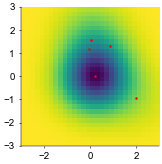

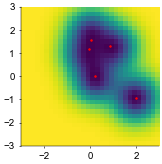

In [100]:
trs = [2, 3]
n = 0

plt.imshow(qf_m[n, ...], extent=[-3, 3, -3, 3], origin='lower', cmap='viridis')
plt.scatter(induc_locs[n, :, 0], induc_locs[n, :, 1], marker='.', color='r')
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.show()

plt.imshow(qf_c[n, ...], extent=[-3, 3, -3, 3], origin='lower', cmap='viridis')
plt.scatter(induc_locs[n, :, 0], induc_locs[n, :, 1], marker='.', color='r')
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.show()

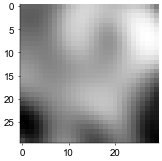

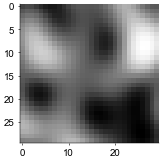

In [46]:
trs = [2, 3]
n = 0

for tr in trs:
    plt.imshow(pf_x[tr, n, ...])
    plt.show()

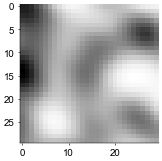

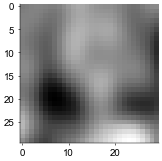

In [47]:
trs = [2, 3]
n = 0

for tr in trs:
    plt.imshow(qf_x[tr, n, ...])
    plt.show()

<a id='stgp'></a>
## STGP

In [101]:
f_dims = 3
spat_dims = 1
x_dims = 1 + spat_dims

num_samps = 5
prng_state = jax.random.PRNGKey(123)

jitter = 1e-12

In [102]:
### inducing points ###
num_t_ind = 3
num_sp_ind = 3
num_induc = num_sp_ind * num_t_ind

site_locs = np.linspace(0., 1., num_t_ind)[None, :].repeat(f_dims, axis=0)  # s       
spatial_locs = jnp.linspace(0., 1., num_sp_ind)[None, :, None].repeat(f_dims, axis=0)

site_obs = 1. * np.ones([f_dims, num_t_ind, num_sp_ind, 1]) + 0. * jax.random.normal(
    jax.random.PRNGKey(123), shape=(f_dims, num_t_ind, num_sp_ind, 1))
site_Lcov = 1. * np.eye(num_sp_ind)[None, None, ...].repeat(
    num_t_ind, axis=1).repeat(f_dims, axis=0)

st_locs = []
for fd in range(f_dims):
    st_locs_ = np.meshgrid(site_locs[fd], spatial_locs[fd])
    st_locs.append(jnp.stack(st_locs_, axis=-1).reshape(-1, x_dims))
st_locs = np.stack(st_locs, axis=0)  # (f_dims, evals, x_dim)

lambda_1 = site_obs.reshape(f_dims, -1, 1)
chol_Lambda_2 = 0.*jnp.eye(num_induc)[None, ...].repeat(f_dims, axis=0)



### spatiotemporal kernel ###
len_t = 1.0*np.ones((f_dims, 1))  # GP lengthscale
var_t = 1.0*np.ones(f_dims)  # GP variance
t_kern = lib.GP.kernels.Matern12(f_dims, variance=var_t, lengthscale=len_t)

len_sp = 1.0*np.ones((f_dims, spat_dims))  # GP lengthscale
var_sp = 1.0*np.ones(f_dims)  # observation noise
sp_kern = lib.GP.kernels.SquaredExponential(f_dims, variance=var_sp, lengthscale=len_sp)

st_kern = lib.GP.kernels.MarkovSparseKronecker(t_kern, sp_kern, spatial_locs)
prod_kern = lib.GP.kernels.Product([t_kern, sp_kern], [[0], [1]])

In [103]:
### spatiotemporal GP ###
spatiotemporal = lib.GP.spatiotemporal.KroneckerLTI(
    st_kern, site_locs, site_obs, site_Lcov, spatial_MF=False, fixed_grid_locs=True)


### sparse GP ###
mean_f = np.zeros(f_dims)

mode = 'tSVGP'
#if mode == 'tSVGP':
sparse = lib.GP.sparse.tSVGP(prod_kern, mean_f, st_locs, lambda_1, chol_Lambda_2, RFF_num_feats=0)

if mode == 'qSVGP':
    Kzz = sparse.kernel.K(sparse.induc_locs, None, False)
    u_mu, u_Lcov = lib.GP.sparse.t_to_q_svgp_moments(Kzz, lambda_1, chol_Lambda_2, 1e-12)
    u_Lcov = 0.*jnp.eye(num_induc)[None, ...].repeat(f_dims, axis=0)
    
    sparse = lib.GP.sparse.qSVGP(prod_kern, mean_f, st_locs, u_mu, u_Lcov, RFF_num_feats=0)

In [104]:
### evaluation ###
t_evals = 30
sp_evals = 30

t_eval = jnp.linspace(-2.1, 3.1, t_evals)
sp_eval = jnp.linspace(-2.1, 3.1, sp_evals)
evalsteps = t_evals*sp_evals

t_eval, x_eval = np.meshgrid(t_eval, sp_eval)
tx_eval = jnp.stack([t_eval, x_eval], axis=-1).reshape(-1, x_dims)
tx_eval = tx_eval[None, None, ...]

or_shape = t_eval.shape
t_eval = t_eval.reshape(1, -1)  # (out_dims, evals, x_dim)
#t_eval_samp = t_eval.repeat(num_samps, axis=0)
x_eval = x_eval.reshape(1, -1, spat_dims)  # (out_dims, evals, x_dim)
#x_eval_samp = x_eval.repeat(num_samps, axis=0)


# st
post_mean, post_cov, KL = spatiotemporal.evaluate_posterior(
    t_eval, x_eval, mean_only=False, compute_KL=True, jitter=1e-8)

post_mean_st = post_mean.reshape(f_dims, *or_shape)
post_cov_st = post_cov.reshape(f_dims, *or_shape)


# sparse
post_mean, post_cov, KL, _ = sparse.evaluate_posterior(
    tx_eval, mean_only=False, diag_cov=True, compute_KL=True, compute_aux=False, jitter=1e-8)


#post_cov = post_cov[..., jnp.arange(evalsteps), jnp.arange(evalsteps)][..., None]

post_mean_sparse = post_mean.reshape(f_dims, *or_shape)
post_cov_sparse = post_cov.reshape(f_dims, *or_shape)

tx_eval = tx_eval.reshape(*or_shape, -1)

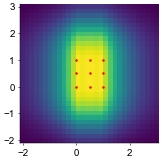

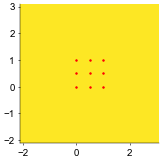

In [105]:
n = 0

plt.scatter(st_locs[n, :, 0], st_locs[n, :, 1], marker='.', c='r')
plt.imshow(post_mean_sparse[n, ...], 
           extent=[tx_eval[..., 0].min(), tx_eval[..., 0].max(), 
                   tx_eval[..., 1].min(), tx_eval[..., 1].max()], 
           aspect='equal', origin='lower', cmap='viridis')
plt.show()

plt.scatter(st_locs[n, :, 0], st_locs[n, :, 1], marker='.', c='r')
plt.imshow(post_cov_sparse[n, ...], 
           extent=[tx_eval[..., 0].min(), tx_eval[..., 0].max(), 
                   tx_eval[..., 1].min(), tx_eval[..., 1].max()], 
           aspect='equal', vmin=0., origin='lower', cmap='viridis')
plt.show()

In [ ]:
n = 0

plt.scatter(st_locs[n, :, 0], st_locs[n, :, 1], marker='.', c='r')
plt.imshow(post_mean_st[n, ...], 
           extent=[tx_eval[..., 0].min(), tx_eval[..., 0].max(), 
                   tx_eval[..., 1].min(), tx_eval[..., 1].max()], 
           aspect='equal', origin='lower', cmap='viridis')
plt.show()

plt.scatter(st_locs[n, :, 0], st_locs[n, :, 1], marker='.', c='r')
plt.imshow(post_cov_st[n, ...], 
           extent=[tx_eval[..., 0].min(), tx_eval[..., 0].max(), 
                   tx_eval[..., 1].min(), tx_eval[..., 1].max()], 
           aspect='equal', vmin=0., origin='lower', cmap='viridis')
plt.show()

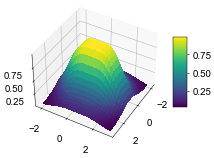

In [95]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.view_init(elev=40., azim=30.)

surf = ax.plot_surface(tx_eval[..., 0], tx_eval[..., 1], post_mean_sparse[n, ...], cmap='viridis',
                       linewidth=0, antialiased=False)

ax.zaxis.set_major_formatter('{x:.02f}')

fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

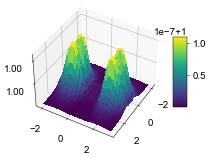

In [96]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.view_init(elev=40., azim=30.)

surf = ax.plot_surface(tx_eval[..., 0], tx_eval[..., 1], post_cov_sparse[n, ...], cmap='viridis',
                       linewidth=0, antialiased=False)

ax.zaxis.set_major_formatter('{x:.02f}')

fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

In [9]:
prng_state = jax.random.PRNGKey(123)
jitter = 1e-6

grid = True
n_samp = 10

if grid: # grid
    xx = np.meshgrid(*[np.linspace(-3, 3, 30) for _ in range(x_dims)])
    xx = jnp.stack(xx, axis=-1)
    
    or_shape = xx.shape[:-1]
    xx = xx.reshape(-1, 1, x_dims).repeat(n_samp, axis=1)  # (evals, samp, x_dim)
    
    pf_x = obs.sample_prior(prng_state, xx, jitter)  # (evals, samp, f_dim)
    pf_x = pf_x.reshape(*or_shape, n_samp, -1)
    
    qf_x, KL = obs.sample_posterior(prng_state, xx, jitter, compute_KL=True) # (evals, samp, f_dim)
    qf_x = qf_x.reshape(*or_shape, n_samp, -1)
    

(2, 3000)

In [3]:
# Synthetic data
sample_bin, track_samples, x_t, y_t, s_t, hd_t, theta_t, dir_t, \
    syn_t_spike, spike_samples, neurons, \
    left_x, right_x, bottom_y, top_y = pickle.load(open('./data/gauss_spat_IPP.p', 'rb'))

fac = 1000.

max_speed = s_t.max()/fac
wrap_theta_t = utils.signal.WrapPi(theta_t, True)

right_x = right_x/fac
left_x = left_x/fac
top_y = top_y/fac
bottom_y = bottom_y/fac

arena_width = right_x - left_x
arena_height = top_y - bottom_y
behav_data = [x_t/fac, y_t/fac]


bin_size = 20
tbin, resamples, rc_t, (rx_t, ry_t, rtheta_t) = \
    utils.neural.bin_data(bin_size, sample_bin, syn_t_spike, track_samples, 
                          (x_t, y_t, theta_t), average_behav=True, binned=False)


### Regression comparison
Comparing SVGP, inverse free SVGP, ...

### Inducing points and expressivity, nonconvexity analysis

In [5]:
def compute_error(mode, glm_rate, true_field, unit=0):
    if mode == 'pos':
        grid_size = (int(arena_width/10), int(arena_height/10))
        grid_shape = [[left_x, right_x], [bottom_y, top_y]]
        
        def func(pos):
            prevshape = pos.shape[1:]
            x = pos[0].flatten()
            y = pos[1].flatten()
            covariates = [x, y]
            return glm_rate.eval_rate(covariates, unit).reshape(*prevshape)
        
    elif mode == 'pos_theta':
        grid_size = (int(arena_width/10), int(arena_height/10), 30)
        grid_shape = [[left_x, right_x], [bottom_y, top_y], [0., 2*np.pi]]
        
        def func(pos):
            prevshape = pos.shape[1:]
            x = pos[0].flatten()
            y = pos[1].flatten()
            theta = pos[2].flatten()
            covariates = [x, y, theta]
            return glm_rate.eval_rate(covariates, unit).reshape(*prevshape)
        
    elif mode == 'pos_theta_hd':
        grid_size = (int(arena_width/20), int(arena_height/20), 10, 10)
        grid_shape = [[left_x, right_x], [bottom_y, top_y], [0., 2*np.pi], [0., 2*np.pi]]
        
        def func(pos):
            prevshape = pos.shape[1:]
            x = pos[0].flatten()
            y = pos[1].flatten()
            theta = pos[2].flatten()
            hd = pos[3].flatten()
            covariates = [x, y, theta, hd]
            return glm_rate.eval_rate(covariates, unit).reshape(*prevshape)
        
    elif mode == 'pos_speed_theta_hd':
        grid_size = (int(arena_width/20), int(arena_height/20), 10, 10, 10)
        grid_shape = [[left_x, right_x], [bottom_y, top_y], [0, maxspeed], [0., 2*np.pi], [0., 2*np.pi]]
        
        def func(pos):
            prevshape = pos.shape[1:]
            x = pos[0].flatten()
            y = pos[1].flatten()
            s = pos[2].flatten()
            theta = pos[3].flatten()
            hd = pos[4].flatten()
            covariates = [x, y, s, theta, hd]
            return glm_rate.eval_rate(covariates, unit).reshape(*prevshape)
        
    elif mode == 'full':
        grid_size = (int(arena_width/10), int(arena_height/10), 30)
        grid_shape = [[left_x, right_x], [bottom_y, top_y], [0., 2*np.pi]]
        
        def func(pos):
            prevshape = pos.shape[1:]
            x = pos[0].flatten()
            y = pos[1].flatten()
            theta = pos[2].flatten()
            covariates = [x, y, theta]
            return glm_rate.eval_rate(covariates, unit).reshape(*prevshape)
        
    return ((tools.compute_mesh(grid_size, grid_shape, func)[1]-true_field)**2).mean()

In [ ]:
# GP with variable regressors model fit and nonconvexity
num_induc_arr = [8, 16, 32, 64]
modes = ['pos', 'pos_theta', 'pos_theta_hd', 'pos_speed_theta_hd']
trials = 5

R_2 = []
NLL = []
for mode in modes:
    print(mode)
    R_2_ = []
    NLL_ = []
    
    # generate data
    true_field, behav_tuple, rc_t, tbin, maxspeed = generate_data(mode)
    
    for num_induc in num_induc_arr:      
        
        R_2__ = []
        NLL__ = []
        retries = 0
        for trial in range(trials):
            while True:
                try:
                    covariates, kt, ind_list, units_ = GP_params(mode, behav_tuple, num_induc, maxspeed)
                    units = 1

                    inducing_points = np.array(ind_list).T[None, ...].repeat(units_, axis=0)
                    glm_rate = mdl.nonparametrics.GP_covariates(units, inducing_points, kt,
                                                                ([None],)*len(covariates), ([None],)*len(covariates), 
                                                                link='exp', shared_kernel_params=True,
                                                                full_cov_fit=False, 
                                                                mean_ini=np.zeros((1, units, 1)), jitter=1e-5)
                    glm_rate.set_params(tbin)

                    #shape = np.ones(1)
                    #renewal_dist = mdl.likelihoods.Gamma(units, 'exp', shape)
                    renewal_dist = mdl.likelihoods.Poisson(units, 'exp')
                    renewal_dist.set_params(tbin)

                    glm = mdl.inference.nll_optimized([glm_rate], renewal_dist)
                    glm.preprocess(list(covariates), covariates[0].shape[0], rc_t, batch_size=100000)
                    glm.to(dev)

                    # fit
                    sch = lambda o: optim.lr_scheduler.MultiplicativeLR(o, lambda e: 0.9)
                    opt_tuple = (optim.Adam, 100, sch)
                    opt_lr_dict = {'default': 5*1e-2}
                    glm.set_optimizers(opt_tuple, opt_lr_dict)

                    annealing = lambda x: min(1.0, 0.002*x)
            
                    losses = glm.fit(3000, margin=1e1, premature=100, anneal_func=annealing, cov_samples=1, ll_samples=10, pred_ll=False)
                    break
                except (RuntimeError, AssertionError):
                    print('Retrying...')
                    if retries > 20: # max retries
                        print('Stopped.')
                        raise ValueError
                    retries += 1

            plt.figure()
            plt.plot(losses)
            plt.xlabel('epoch')
            plt.ylabel('NLL')
            plt.show()

            # rate error
            R_2__.append(compute_error(mode, glm_rate, true_field))
            NLL__.append(losses[-1])
            
        R_2_.append(R_2__)
        NLL_.append(NLL__)
        
    R_2.append(R_2_)
    NLL.append(NLL_)
        
R_2 = np.array(R_2) # modes, num_induc, trials
NLL = np.array(NLL)

Generating animal behaviour...
Computing true field...
Sampling spike trains...


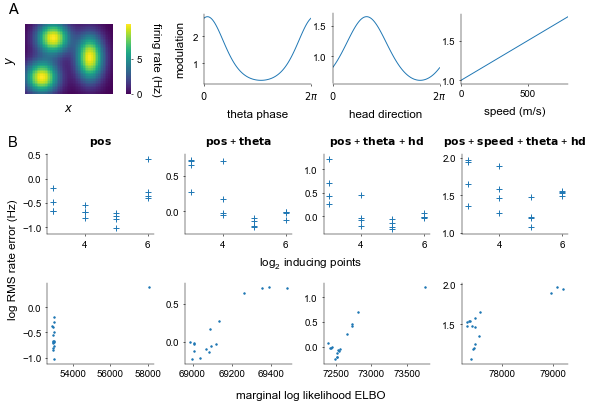

In [43]:
fig = plt.figure(figsize=(8, 5))


# visualization
fig.text(0.0, 1.0, 'A', fontsize=15)
widths = [1]
heights = [1]
spec = fig.add_gridspec(ncols=1, nrows=1, width_ratios=widths, height_ratios=heights, 
                        wspace=0.4, left=0., right=.25, bottom=0.77, top=.97)

ax = fig.add_subplot(spec[0, 0])
grid_shape = [[left_x, right_x], [bottom_y, top_y]]
field = generate_data('pos', track_samples=1)[0]
ax.set_title('{:.0f} Hz'.format(field.max()), fontsize=12)
_, ax = tools.visualize_field(field, grid_shape, figax=(fig, ax), ticktitle='firing rate', 
                              ticks=[0, field.max()], ticklabels=['0', 'max'])
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')


widths = [1, 1, 1]
heights = [1]
spec = fig.add_gridspec(ncols=3, nrows=1, width_ratios=widths, height_ratios=heights, 
                        wspace=0.2, left=.35, right=1., bottom=0.8, top=1.0)

ax = fig.add_subplot(spec[0, 0])
angles = np.linspace(0, 2*np.pi, 100)
angles_0 = 0.2
beta = 1.0
mod = np.exp(beta*np.cos(angles-angles_0))
ax.plot(angles, mod)
ax.set_xlabel('theta phase')
ax.set_ylabel('modulation')
ax.set_xticks([0, 2*np.pi])
ax.set_xticklabels([r'$0$', r'$2\pi$'])
ax.set_xlim(0, 2*np.pi)

ax = fig.add_subplot(spec[0, 1])
angles = np.linspace(0, 2*np.pi, 100)
angles_0 = 2.0
beta = 0.5
mod = np.exp(beta*np.cos(angles-angles_0))
ax.plot(angles, mod)
ax.set_xlabel('head direction')
ax.set_xticks([0, 2*np.pi])
ax.set_xticklabels([r'$0$', r'$2\pi$'])
ax.set_xlim(0, 2*np.pi)

ax = fig.add_subplot(spec[0, 2])
s = np.linspace(0, 800, 100)
s_mod = 0.001
mod = 1.+s*s_mod
ax.plot(s, mod)
ax.set_xlabel('speed (m/s)')
ax.set_xlim(0, 800)

# validation
fig.text(0.0, 0.62, 'B', fontsize=15)
ncols = 4
widths = [1]*ncols
heights = [1, 1]
spec = fig.add_gridspec(ncols=ncols, nrows=2, width_ratios=widths, height_ratios=heights, 
                        wspace=0.3, hspace=0.6, left=0.07, right=1., bottom=0.0, top=0.6)

n_ = np.array(num_induc_arr)[:, None].repeat(trials, axis=1)

modes = [r'$\bf{pos}$', r'$\bf{pos}$ + $\bf{theta}$', r'$\bf{pos}$ + $\bf{theta}$ + $\bf{hd}$', 
         r'$\bf{pos}$ + $\bf{speed}$ + $\bf{theta}$ + $\bf{hd}$']
for k in range(ncols):
    ax = fig.add_subplot(spec[0, k])
    ax.scatter(np.log2(n_), 0.5*np.log(R_2[k, :]), marker='+', s=50)
    ax.set_title(modes[k], pad=10, fontsize=11)

fig.text(0.54, 0.28, r'$\mathregular{log_2}$ inducing points', ha='center', fontsize=12)

for k in range(ncols):
    ax = fig.add_subplot(spec[1, k])
    #r, r_p = scstats.pearsonr(NLL[k][NLL[k] is not np.nan].flatten(), 
    #                          R_2[k][R_2[k] is not np.nan].flatten()) # Pearson r correlation test
    ax.ticklabel_format(axis='x', style='sci')
    ax.scatter(NLL[k], 0.5*np.log(R_2[k]), marker='.')
    #fig.text(0.2, 0.8, '$r={:.2f}$ ($p={:.2f}$)'.format(r, r_p), fontsize=11,
    #         transform=ax.transAxes)
    #axes[ncols+0].set_ylabel('$R^2$')
    
fig.text(0.0, 0.3, 'log RMS rate error (Hz)', va='center', rotation=90, fontsize=12)

fig.text(0.54, -0.1, 'marginal log likelihood ELBO', ha='center', fontsize=12)

plt.savefig('output/GP_validation.svg')
plt.savefig('output/GP_validation.pdf')
plt.show()

In [37]:
R_2 = np.load('saves/R_2_20201106.npy')
NLL = np.load('saves/NLL_20201106.npy')

import time
np.save('../data/R_2'+time.strftime("_%Y%m%d"), R_2)
np.save('../data/NLL'+time.strftime("_%Y%m%d"), NLL)

### Multi-regressor validation

In [7]:
# generate data
true_field, behav_tuple, rc_t, tbin, maxspeed = generate_data('pos_speed_theta_hd', track_samples=3000000)

Generating animal behaviour...



Computing true field...
Sampling spike trains...


In [ ]:
def compute_stats(glm_rate, t_spike): # statistics
    bs = 5000
    T = 100000
    N = int(np.ceil(T/bs))
    rate_model= []
    t_spike = t_spike[t_spike < T]

    for n in range(N):
        covariates_ = [b[n*bs:(n+1)*bs] for b in behav_data]
        rate_model += [glm_rate.eval_rate(covariates_, [0])[0]]

    rate_model = np.concatenate(rate_model)

    # Overdispersion count method
    #traj_len = 1000
    #q_cdf_, q_order_, py, T_DS, T_KS, s_DS, s_KS_, p_DS_, p_KS_, traj_lens = \
    #    stats.count_KS_method(sample_bin, t_spike, rate_model, traj_len, min_spikes=10, repeat=1)

    # ISI KS-method
    dist_isi = mdl.point_process.ISI_gamma(np.array([1.0]))
    q_cdf, Z_DS, T_KS, s_DS, s_KS, p_DS, p_KS = \
        stats.ISI_KS_method(dist_isi, sample_bin, t_spike, rate_model)

    return q_cdf, Z_DS, T_KS, s_KS

def compute_NLL(glm_rate, covariates, spiketrain):
    glm_rate.eval_rate(covariates)

In [ ]:
# GP with variable regressors model fit and nonconvexity
modes = ['pos', 'pos_theta', 'pos_theta_hd', 'pos_speed_theta_hd']
folds = 10
folds_eval = 5

R_2 = []
NLL = []
for mode in modes:
    print(mode)
    R_2_ = []
    NLL_ = []
    
    # generate data
    true_field, behav_tuple, rc_t, tbin, maxspeed = generate_data(mode)
    
    cv_set = neural_utils.SpikeTrainCV(folds, rc_t[u:u+1], track_samples, behav_data)
    CVs[u, k] = neural_utils.model_cv(rate_func, cv_set)
    
    if neuron is None:
        cv_nll = []
        for ftrain, fcov, vtrain, vcov in cv_set:
            glm, _ = rate_func(fcov, ftrain)
            glm.preprocess(vcov, len(vcov[0]), vtrain, batch_size=len(vcov[0]))
            #glm.to(dev)
            cv_nll.append(glm.nll(0, cov_samples=1, ll_samples=1))
        return np.array(cv_nll)
            
    else:
        cv_nll = []
        for n in neuron:
            nll = []
            for ftrain, fcov, vtrain, vcov in cv_set:
                glm, _ = rate_func(fcov, ftrain)
                glm.preprocess(vcov, len(vcov[0]), vtrain, batch_size=len(vcov[0]))
    
    for gp_mode in modes:      
        
        R_2__ = []
        NLL__ = []
        retries = 0
        for fold in np.arange(folds_eval):
            while True:
                try:
                    covariates, kt, ind_list, units_ = GP_params(gp_mode, behav_tuple, 32, maxspeed)
                    units = 1

                    inducing_points = np.array(ind_list).T[None, ...].repeat(units_, axis=0)
                    glm_rate = mdl.nonparametrics.GP_covariates(units, inducing_points, kt,
                                                                [(None,)]*len(covariates), [(None,)]*len(covariates), 
                                                                link='exp', shared_kernel_params=True,
                                                                full_cov_fit=False, 
                                                                mean_ini=np.zeros((1, units, 1)))
                    glm_rate.set_params(tbin, jitter=1e-5)

                    renewal_dist = mdl.likelihoods.Poisson(units, 'exp')
                    renewal_dist.set_params(tbin)

                    glm = mdl.inference.nll_optimized([glm_rate], renewal_dist)
                    glm.preprocess(list(covariates), covariates[0].shape[0], rc_t, batch_size=100000)
                    glm.to(dev)

                    # fit
                    sch = lambda o: optim.lr_scheduler.MultiplicativeLR(o, lambda e: 0.9)
                    opt_tuple = (optim.Adam, 100, sch)
                    opt_lr_dict = {'default': 5*1e-2}
                    glm.set_optimizers(opt_tuple, opt_lr_dict)

                    annealing = lambda x: min(1.0, 0.002*x)

                    losses = glm.fit(3000, margin=1e1, premature=100, anneal_func=annealing, cov_samples=1, ll_samples=10, pred_ll=False)
                    break
                except (RuntimeError, AssertionError):
                    print('Retrying...')
                    if retries > 20: # max retries
                        print('Stopped.')
                        raise ValueError
                    retries += 1

            plt.figure()
            plt.plot(losses)
            plt.xlabel('epoch')
            plt.ylabel('NLL')
            plt.show()

        # rate error            
        R_2_.append()
        NLL_.append()
        
    R_2.append(R_2_)
    NLL.append(NLL_)
        
R_2 = np.array(R_2) # modes, folds
NLL = np.array(NLL)

### Multi-regressor example

In [223]:
# generate data
true_field, behav_tuple, rc_t, tbin, maxspeed = generate_data('pos_speed_theta_hd', track_samples=3000000)

Generating animal behaviour...



Computing true field...
Sampling spike trains...



Stopped at epoch 404.


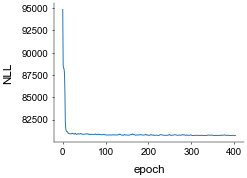

In [224]:
# GP with variable regressors model fit and nonconvexity
num_induc = 32

while True:
    try:
        covariates, kt, ind_list, units_ = GP_params('pos_speed_theta_hd', behav_tuple, num_induc, maxspeed)
        units = 1

        inducing_points = np.array(ind_list).T[None, ...].repeat(units_, axis=0)
        glm_rate = mdl.nonparametrics.GP_covariates(units, inducing_points, kt,
                                                    ([None],)*len(covariates), ([None],)*len(covariates), 
                                                    inv_link='exp', shared_kernel_params=True,
                                                    full_cov_fit=False, 
                                                    mean_ini=np.zeros((1, units, 1)), jitter=1e-5)
        glm_rate.set_params(tbin)

        #shape = np.ones(1)
        #renewal_dist = mdl.likelihoods.Gamma(units, 'exp', shape)
        renewal_dist = mdl.likelihoods.Poisson(units, 'exp')
        renewal_dist.set_params(tbin)

        glm = mdl.inference.nll_optimized([glm_rate], renewal_dist)
        glm.preprocess(list(covariates), covariates[0].shape[0], rc_t, batch_size=100000)
        glm.to(dev)

        # fit
        sch = lambda o: optim.lr_scheduler.MultiplicativeLR(o, lambda e: 0.9)
        opt_tuple = (optim.Adam, 100, sch)
        opt_lr_dict = {'default': 5*1e-2}
        glm.set_optimizers(opt_tuple, opt_lr_dict)

        annealing = lambda x: min(1.0, 0.002*x)

        losses = glm.fit(3000, margin=1e1, premature=100, anneal_func=annealing, cov_samples=1, ll_samples=10, pred_ll=False)
        break
    except (RuntimeError, AssertionError):
        print('Retrying...')
        if retries > 20: # max retries
            print('Stopped.')
            raise ValueError
        retries += 1

plt.figure()
plt.plot(losses)
plt.xlabel('epoch')
plt.ylabel('NLL')
plt.show()

In [225]:
place_field = []
lower_s = []
mean_s = []
upper_s = []
lower_th = []
mean_th = []
upper_th = []
lower_hd = []
mean_hd = []
upper_hd = []

# evaluate tuning
SP = 500.
TH = 2.
HD = 1.
X = [100., 100., 200.]
Y = [100., 150., 200.]
K = len(X)


# Place field
grid_size = [int(arena_width/10), int(arena_height/10)]
grid_shape = [[left_x, right_x], [bottom_y, top_y]]

def func(pos):
    prevshape = pos.shape[1:]
    x = pos[0].flatten()
    y = pos[1].flatten()
    covariates = (x, y, SP*np.ones_like(x), \
                  TH*np.ones_like(x), HD*np.ones_like(x))
    return glm_rate.eval_rate(covariates, [0])[0].reshape(*prevshape)

(xx, yy), place_field_ = tools.compute_mesh(grid_size, grid_shape, func)
place_field.append(place_field_)
    
    
for n in range(K):
    # GP tuning
    steps= 100

    covariates = (X[n]*np.ones(steps), Y[n]*np.ones(steps), np.linspace(0, maxspeed, steps), \
                  TH*np.ones(steps), HD*np.ones(steps))
    lower, mean, upper = glm_rate.eval_rate(covariates, [0], False)
    lower_s.append(lower[0])
    mean_s.append(mean[0])
    upper_s.append(upper[0])

    covariates = (X[n]*np.ones(steps), Y[n]*np.ones(steps), SP*np.ones(steps), \
                  np.linspace(0, 2*np.pi, steps), HD*np.ones(steps))
    lower, mean, upper = glm_rate.eval_rate(covariates, [0], False)
    lower_th.append(lower[0])
    mean_th.append(mean[0])
    upper_th.append(upper[0])


    covariates = (X[n]*np.ones(steps), Y[n]*np.ones(steps), SP*np.ones(steps), \
                  TH*np.ones(steps), np.linspace(0, 2*np.pi, steps))
    lower, mean, upper = glm_rate.eval_rate(covariates, [0], False)
    lower_hd.append(lower[0])
    mean_hd.append(mean[0])
    upper_hd.append(upper[0])

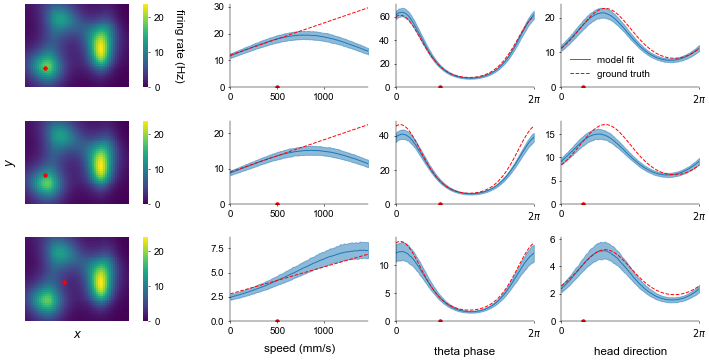

In [238]:
# example fit
fig = plt.figure(figsize=(10, 6))


# full tuning plot
widths = [1]
heights = np.ones(K)
nrows = K
ncols = 1
spec_ = fig.add_gridspec(ncols=ncols, nrows=nrows, width_ratios=widths,
                         height_ratios=heights, left=0.0, right=0.25)

# Place field
grid_extent = (left_x, right_x, bottom_y, top_y)

for k in range(K):
    ax = fig.add_subplot(spec_[k, 0])
    #ax.text(-0.08, 1.02, 'A', transform=fig.transFigure, size=15)
    if k == 0:
        ticktitle = 'firing rate (Hz)'
    else:
        ticktitle = ''
    _, ax = tools.visualize_field(place_field[0], grid_shape, ticktitle=ticktitle, figax=(fig, ax))
    #tools.decorate_ax(ax, xlim=[left_x, right_x], ylim=[bottom_y, top_y])
    ax.scatter(X[k], Y[k], color='r', marker='.', s=50)
    if k == K // 2:
        ax.set_ylabel(r'$y$')
    if k == K-1:
        ax.set_xlabel(r'$x$')
    #ax.set_title(r'neuron 31', fontsize=12, pad=10)
    
    

# GP tuning
widths = [1, 1, 1]
heights = np.ones(K)
nrows = K
ncols = 3
spec = fig.add_gridspec(ncols=ncols, nrows=nrows, width_ratios=widths,
                         height_ratios=heights, left=0.33, right=1.0)


steps= 100
y_lim = [100.0, 70.0, 35.0]


for k in range(K):
    c = np.linspace(0, maxspeed, steps)
    ax = fig.add_subplot(spec[k, 0])
    line, = ax.plot(c, mean_s[k])
    ax.fill_between(
        c, lower_s[k],
        upper_s[k], color=line.get_color(), alpha=0.5
    )
    #ax2.scatter(loc_x, loc_rate, marker='.', s=10)

    if k == K-1:
        ax.set_xlabel('speed (mm/s)')
    #ax.set_ylabel('firing rate (Hz)')
    ax.set_xlim(0, maxspeed)
    ax.scatter(SP, 0, c='r', marker='.', s=50)
    s = np.linspace(0, maxspeed, steps)
    s_mod = 0.001
    mod = 1.+s*s_mod
    ig = np.argmin(np.abs(np.linspace(0, maxspeed, steps) - SP))
    ax.plot(s, mod*mean_s[k][ig]/mod[ig], 'r--')
    ax.set_ylim(0)#, y_lim[k])
    

    c = np.linspace(0, 2*np.pi, steps)
    ax = fig.add_subplot(spec[k, 1])
    line, = ax.plot(c, mean_th[k])
    ax.fill_between(
        c, lower_th[k],
        upper_th[k], color=line.get_color(), alpha=0.5
    )
    #ax2.scatter(loc_x, loc_rate, marker='.', s=10)

    if k == K-1:
        ax.set_xlabel('theta phase')
    ax.set_xlim(0, 2*np.pi)
    ax.set_xticks([0, 2*np.pi])
    ax.set_xticklabels(['0', r'$2\pi$'])
    ax.scatter(TH, 0, c='r', marker='.', s=50)
    angles = np.linspace(0, 2*np.pi, steps)
    angles_0 = 0.2
    beta = 1.0
    mod = np.exp(beta*np.cos(angles-angles_0))
    ig = np.argmin(np.abs(np.linspace(0, 2*np.pi, steps) - TH))
    ax.plot(angles, mod*mean_th[k][ig]/mod[ig], 'r--')
    ax.set_ylim(0)#, y_lim[k])
    

    c = np.linspace(0, 2*np.pi, steps)
    ax = fig.add_subplot(spec[k, 2])
    line, = ax.plot(c, mean_hd[k], label='model fit')
    ax.fill_between(
        c, lower_hd[k],
        upper_hd[k], color=line.get_color(), alpha=0.5
    )
    #ax2.scatter(loc_x, loc_rate, marker='.', s=10)

    if k == K-1:
        ax.set_xlabel('head direction')
    ax.set_xlim(0, 2*np.pi)
    ax.set_xticks([0, 2*np.pi])
    ax.set_xticklabels(['0', r'$2\pi$'])
    ax.scatter(HD, 0, c='r', marker='.', s=50)
    angles = np.linspace(0, 2*np.pi, steps)
    angles_0 = 2.0
    beta = 0.5
    mod = np.exp(beta*np.cos(angles-angles_0))
    ig = np.argmin(np.abs(np.linspace(0, 2*np.pi, steps) - HD))
    ax.plot(angles, mod*mean_hd[k][ig]/mod[ig], 'r--', label='ground truth')
    ax.set_ylim(0)#, y_lim[k])
    
    if k == 0:
        ax.legend()
    

fig.subplots_adjust(hspace=0.4)


plt.savefig('output/GP_regressor.svg')
plt.savefig('output/GP_regressor.pdf')
plt.show()

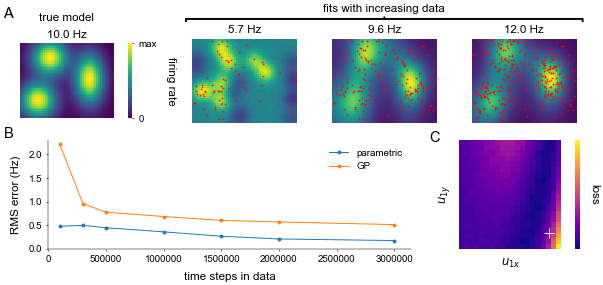

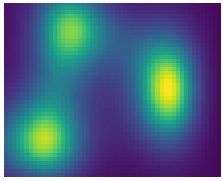

In [324]:
_, ax = tools.visualize_field(field_tuples[6], grid_shape, ticktitle='', cbar=False)

In [320]:
grid_shape = [[left_x, right_x], [bottom_y, top_y]]